In [1]:
# add parent dir to syspath
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
#root_dir = os.path.dirname(parent_dir)
sys.path.insert(0, parent_dir)

In [2]:
import tensorflow as tf

import load_realdata
from ganMetrics.FID import FID_interface
from imageGenerators import distortions
from evaluationModels.scut_wmn.FCSRN import fcsrn
from evaluationModels.scut_wmn import wmn_helpers
from evaluationModels import evalFunctions

import numpy as np
from matplotlib import pyplot as plt
from time import time
from pathlib import Path
import cv2

In [3]:
# For calculating FID, resize without keeping ratio 
fid_inputHeight = 128; fid_inputWidth = 512
fid_inputDims = (fid_inputWidth, fid_inputHeight)
# For training fcsrn, use recommended dimensions and resize while keeping ratio
fcsrn_inputHeight = 48; fcsrn_inputWidth = 160
fcsrn_inputDims = (fcsrn_inputWidth, fcsrn_inputHeight)

In [4]:
# load easy_images as testimages (1000)
# apply distortions
# calculate FID, and/or calculate ARs on FCSR

In [5]:
BATCH_SIZE = 100
EPOCHS = 100

In [6]:
def make_datasets(images, labels):
    X = tf.data.Dataset.from_tensor_slices(images)\
        .cache() \
        .batch(BATCH_SIZE, drop_remainder=True)
    y = tf.data.Dataset.from_tensor_slices(labels)\
        .cache() \
        .batch(BATCH_SIZE, drop_remainder=True)
    return (X, y) 
def add_channels(images, grayscale):
    shape = images.shape
    if len(shape) < 4:
        shape = [d for d in shape]
        shape.append(1)
        images = np.reshape(images, shape)
        if not grayscale:
            images = np.repeat(images, 3, axis=-1)
        print(images.shape)
    return images

# load images for FID

In [7]:
def showImage(image):
    plt.imshow(image, cmap="gray", vmin=0, vmax=255)
    plt.show()
def showImages(images, n=None):
    if n == None:
        n = len(images)
    n = min(len(images), n)
    for i in range(n):
        showImage(images[i])

def apply_distortions(imageset, distFunction):
    result = imageset.copy()
    for image in result:
        distFunction(image)
    return result

# loads wmn_easyimages and applies <distortion_function> to every image.
# loads difficult_images and calculates:
#     FID( distortion_function(easyimages), difficult_images)
#     FID( distortion_function(easyimages), easyimages)
def caluclate_FID(distortion_function, n_show=30):
    starttime = time()
    
    # load real easy images, all 1000, scale with cv2.resize
    images_easy, labels_easy = load_realdata.load_wmr_easy(n_toLoad=None, resizeTo=fid_inputDims, keepRatio=False)    
    n_images = images_easy.shape[0]
    # apply distortion/s to easyimages
    images_easy_distorted, _ = load_realdata.load_wmr_easy(n_toLoad=None, resizeTo=fid_inputDims, keepRatio=False, processImage=distortion_function)
    #images_easy_distorted = apply_distortions(images_easy, distortion_function)
    # load difficult images
    images_diff, labels_diff = load_realdata.load_wmr_diff_test(n_toLoad=None, resizeTo=fid_inputDims, keepRatio=False)
    assert (images_diff.shape[0]) == n_images
    
    
    
    stats_easy = FID_interface.calculate_stats(images_easy)
    stats_distorted = FID_interface.calculate_stats(images_easy_distorted)
    stats_difficult = FID_interface.calculate_stats(images_diff)
    
    fid_easy_distorted = FID_interface.calculate_fid_from_stats(stats_easy, stats_distorted)
    fid_diff_distorted = FID_interface.calculate_fid_from_stats(stats_difficult, stats_distorted)
    #fid_diff_easy = FID_interface.calculate_fid_from_stats(stats_difficult, stats_easy)
    
    print("FID(easy/dist):\t%f" %(fid_easy_distorted))
    print("FID(diff/dist):\t%f" %(fid_diff_distorted))
    #print("FID(diff/easy):\t%f" %(fid_diff_easy))
    
    print("calculation took : %f seconds" % (time() - starttime) )
    
    for i in range(n_show):
        showImage(images_easy_distorted[i])
        
    return (fid_easy_distorted, fid_diff_distorted)
    
    
# loads wmn_easyimages and applies <distortion_function> to every image.
# Trains FCSRN-Model (only) with those images,
# calculates Character-Recognition-Rate (AR) for the trained Model on both easy and difficult images.
def calculate_FCSRN_AR(distortion_function, modelsavepath):
    HEIGHT = 48; WIDTH = 160; CHANNELS = 1
    grayscale = CHANNELS == 1
    IMAGE_SHAPE = (HEIGHT, WIDTH, CHANNELS)
    inputDims = (WIDTH,HEIGHT)
    images_easy, labels_easy = load_realdata.load_wmr_easy(n_toLoad=None, resizeTo=inputDims, keepRatio=True)
    images_easy_distorted, labels_distorted = load_realdata.load_wmr_easy(n_toLoad=None, resizeTo=inputDims, keepRatio=True, processImage=distortion_function)
    images_diff, labels_diff = load_realdata.load_wmr_diff_test(n_toLoad=None, resizeTo=inputDims, keepRatio=True)
    
    
    print("trainimages")
    for i in range(20):
        image = images_easy_distorted[i]
        showImage(image)
    
    # create/load model
    modelExists = (modelsavepath / "checkpoint").exists()
    model = fcsrn(IMAGE_SHAPE, checkpoint_path=modelsavepath)
    
    # train if newly created
    if not modelExists:
        
        # init traindata
        images_train, labels_train = (images_easy_distorted, labels_distorted) 
        images_train = add_channels(images_train, grayscale)
        
        # make datasets
        train_x, train_y = make_datasets(images_train.astype("float"), labels_train)        
        model.train(train_x, train_y, EPOCHS, BATCH_SIZE)
        
    # evaluate
    test_x_diff, test_y_diff = make_datasets(add_channels(images_diff, grayscale).astype("float"), labels_diff)
    test_x_easy, test_y_easy = make_datasets(add_channels(images_easy, grayscale).astype("float"), labels_easy)
    
    N_TEST = images_diff.shape[0]
    total_characters = N_TEST*5
    
    _, ar_diff, _, _ = model.accuracy(test_x_diff, test_y_diff, BATCH_SIZE, total_characters, N_TEST)
    _, ar_easy, _, _ = model.accuracy(test_x_easy, test_y_easy, BATCH_SIZE, total_characters, N_TEST)
    
    print("AR(difficult) = \t%f" % (ar_diff) )
    print("AR(easy) = \t%f" % (ar_easy) )

In [8]:
def ident(image):
    return

def blots_5(image):
    distortions.add_round_blot(image, 5)

def brighten_digits(image, value_range, treshold):
    value = np.random.randint(100,130)
    distortions.brighten_digits(image, value=value, treshold = 50)
    
def blur_region(image):
    kernelSizeRelative = np.random.uniform(0.1,0.2)
    distortions.blur_region(image, kernelSizeRelative)
    
def saltPepper_noise(image):
    if np.random.random() < 0.5:
        distortions.saltPepperNoise(image, 0.1)
    else:
        return
    
def spNoise_region(image):
    distortions.spNoise_region(image)
    
def rotate_small_random(image):
    angle = np.random.randint(-5,5)
    distortions.rotate(image, angle)

# composites
def brighten_blur(image):
    brighten_digits(image)
    blur_region(image)
def blur_blots(image):
    blur_region(image)
    blots_5(image)
def blots_blur(image):
    blots_5(image)
    blur_region(image)   
    
def blur_sp(image):
    blur_region(image)
    spNoise_region(image)
def sp_blur(image):
    spNoise_region(image)
    blur_region(image)
    
def brighten_blur_random(image):
    if np.random.random() < 0.5:
        brighten_digits(image)
    if np.random.random() < 0.5:
        blur_region(image)
    
#caluclate_FID(ident)

# first, search for small fid

FID(easy/dist):	156.344187
FID(diff/dist):	167.217171
calculation took : 61.633384 seconds


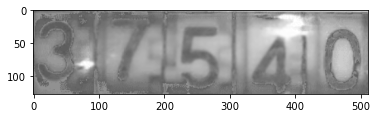

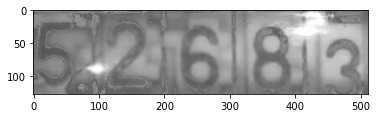

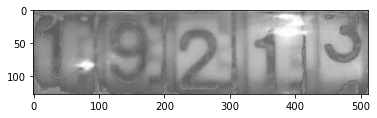

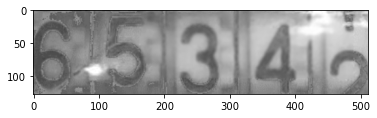

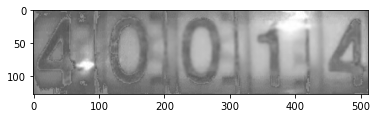

156.3441868723142
167.21717064778855


In [25]:
fid_easy_distorted, fid_diff_distorted = caluclate_FID(
                                                    lambda image: brighten_blur(image, 60, 90, 0.6, 2, 0.025),
                                                    n_show=5)
print(fid_easy_distorted)
print(fid_diff_distorted)

FID(easy/dist):	62.765164
FID(diff/dist):	235.108665
calculation took : 60.261757 seconds


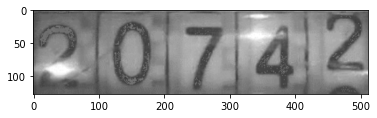

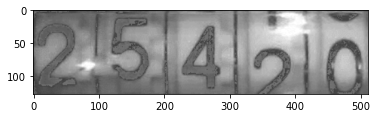

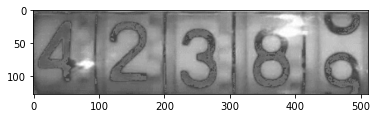

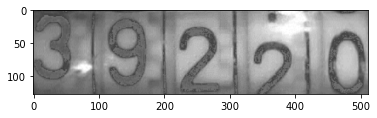

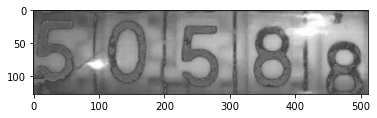

FID(easy/dist):	103.251663
FID(diff/dist):	208.241487
calculation took : 61.098260 seconds


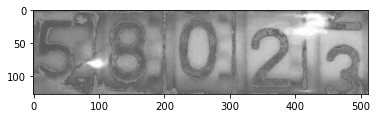

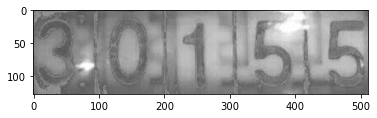

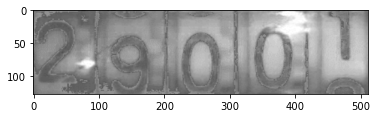

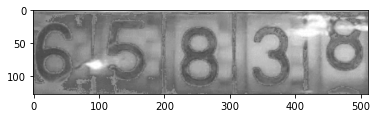

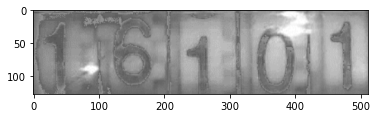

FID(easy/dist):	133.538247
FID(diff/dist):	216.882399
calculation took : 59.841756 seconds


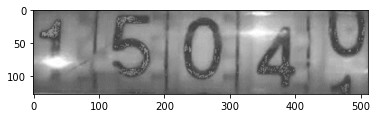

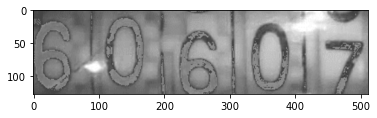

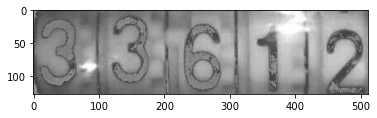

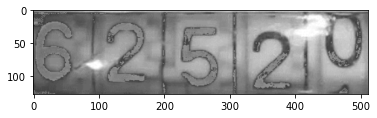

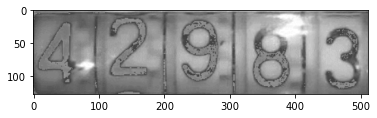

FID(easy/dist):	155.952480
FID(diff/dist):	206.483255
calculation took : 61.497327 seconds


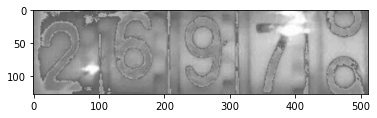

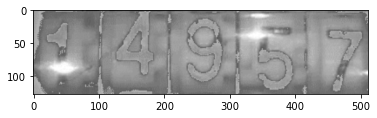

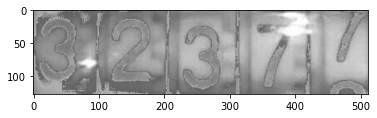

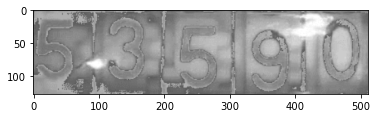

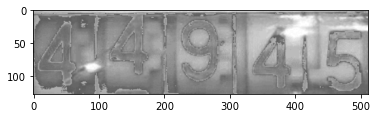

FID(easy/dist):	69.672756
FID(diff/dist):	215.609183
calculation took : 61.143682 seconds


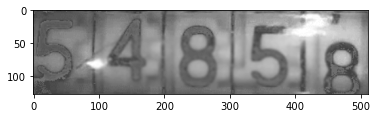

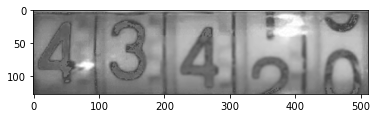

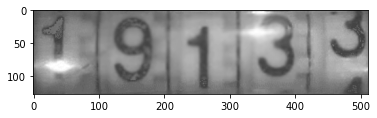

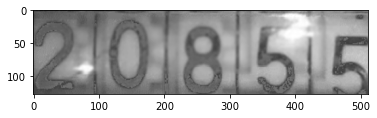

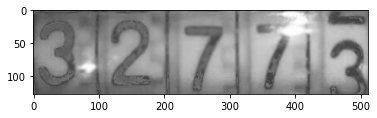

FID(easy/dist):	157.282601
FID(diff/dist):	166.595463
calculation took : 61.843036 seconds


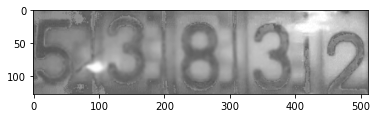

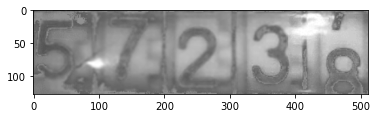

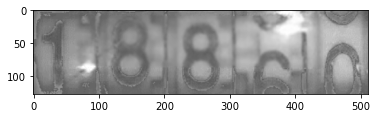

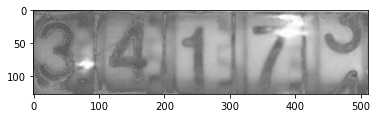

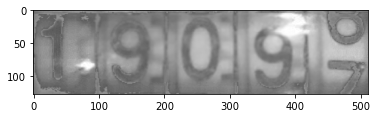

FID(easy/dist):	120.682366
FID(diff/dist):	200.504644
calculation took : 61.526841 seconds


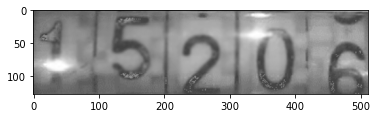

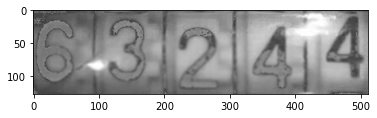

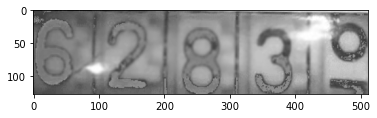

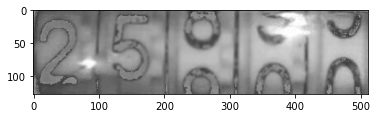

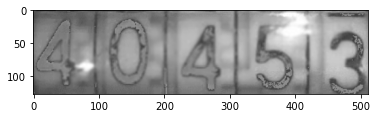

FID(easy/dist):	214.646309
FID(diff/dist):	174.230847
calculation took : 60.905898 seconds


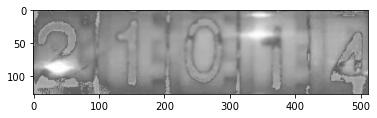

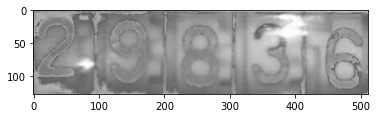

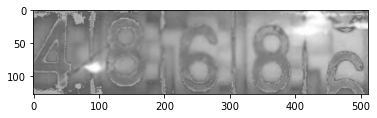

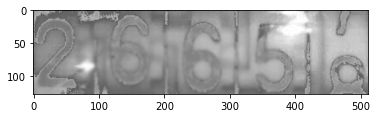

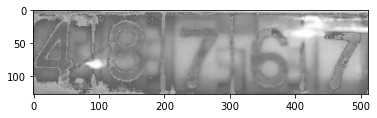

FID(easy/dist):	153.754815
FID(diff/dist):	203.506194
calculation took : 62.541083 seconds


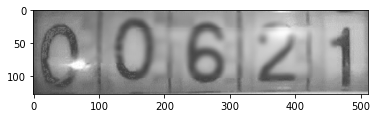

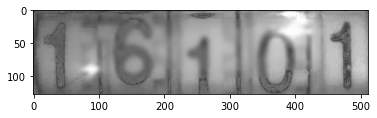

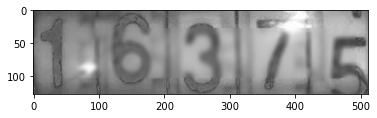

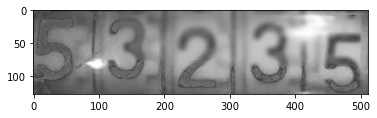

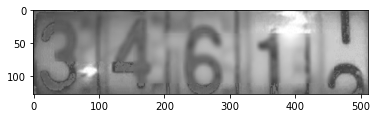

FID(easy/dist):	236.451866
FID(diff/dist):	173.555397
calculation took : 61.565901 seconds


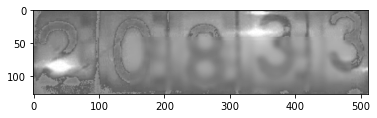

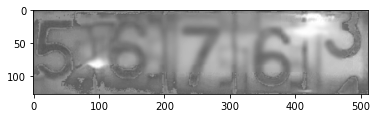

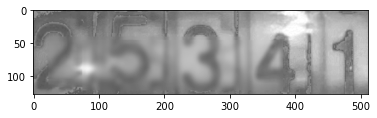

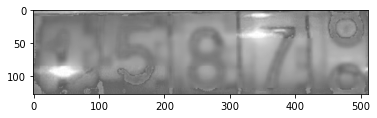

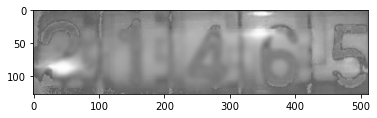

FID(easy/dist):	187.057592
FID(diff/dist):	200.227546
calculation took : 63.154946 seconds


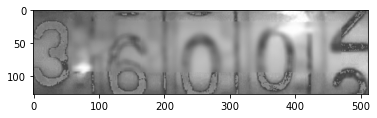

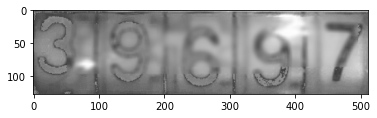

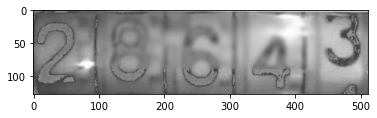

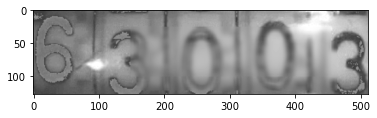

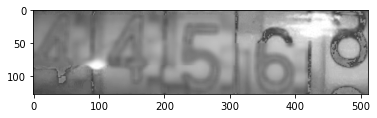

FID(easy/dist):	287.887124
FID(diff/dist):	185.729446
calculation took : 59.085071 seconds


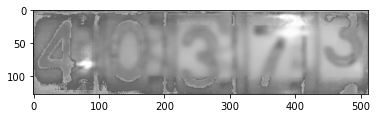

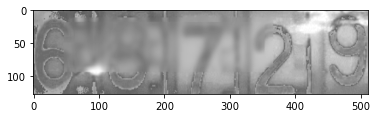

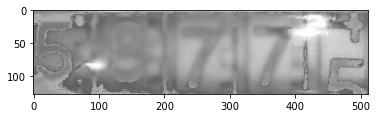

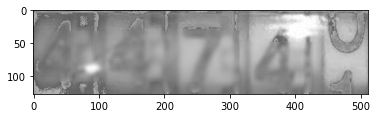

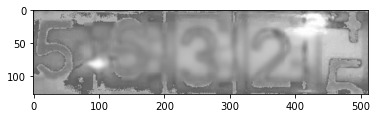

FID(easy/dist):	211.247881
FID(diff/dist):	189.606922
calculation took : 61.003053 seconds


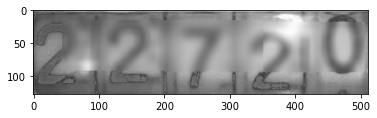

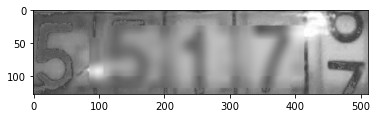

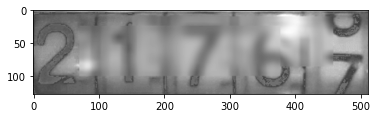

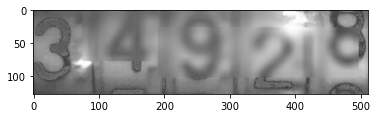

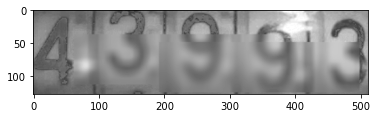

FID(easy/dist):	263.594148
FID(diff/dist):	166.914744
calculation took : 60.525731 seconds


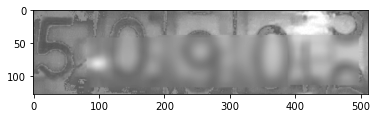

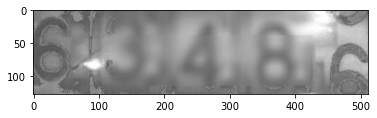

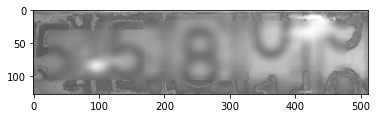

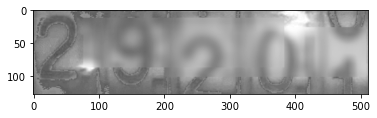

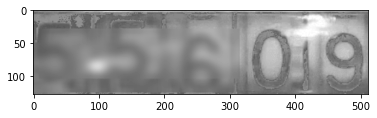

FID(easy/dist):	231.027656
FID(diff/dist):	189.767605
calculation took : 60.010555 seconds


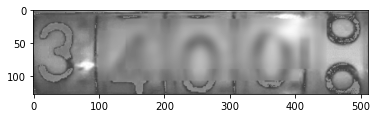

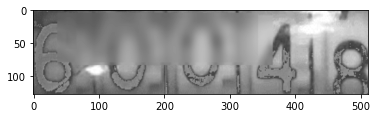

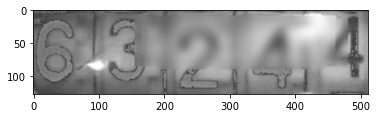

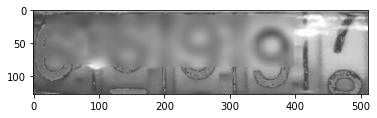

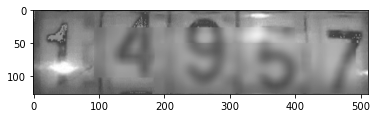

FID(easy/dist):	294.310692
FID(diff/dist):	188.644705
calculation took : 59.103708 seconds


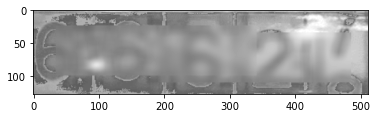

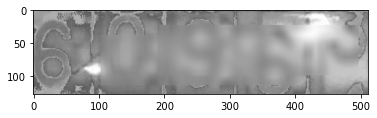

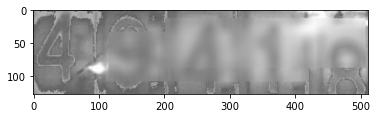

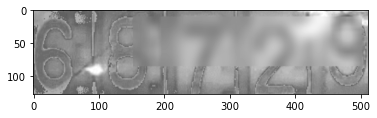

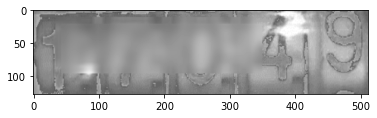

brighten_value	brighten_treshold	blur_size	blur_n	blur_kernel	fid(easy,dist)	fid(diff,dist)


IndexError: tuple index out of range

In [22]:
# brigthen, then blur locally
def brighten_blur(image, br_val, br_tresh, bl_size, bl_n, bl_kernel):
    distortions.brighten_digits(image, br_val, br_tresh)
    blur_squares(image, bl_size, bl_n, bl_kernel)

kernels = [0.01,0.025,0.05,0.1]
bl_size = 0.6
bl_n = 2
br_val = [60,90]
br_tr = [60,90]
results = []
for k_rel in kernels:
    for val in br_val:
        for tr in br_tr:
            fid_easy_distorted, fid_diff_distorted = caluclate_FID(
                                                    lambda image: brighten_blur(image, val, tr, bl_size, bl_n, k_rel),
                                                    n_show=5)
            results.append( (val, tr, bl_size, bl_n, k_rel, fid_easy_distorted, fid_diff_distorted) )

print("brighten_value\tbrighten_treshold\tblur_size\tblur_n\tblur_kernel\tfid(easy,dist)\tfid(diff,dist)")
for row in results:
    print("%d\t%d\t%f\t%d\t%f\t%f\t%f" % (row[0],row[1],row[2],row[3],row[4],row[5],row[6]) )

In [24]:
print("brighten_value\tbrighten_treshold\tblur_size\tblur_n\tblur_kernel\tfid(easy,dist)\tfid(diff,dist)")
for row in results:
    print("%d\t%d\t%f\t%d\t%f\t%f\t%f" % (row[0],row[1],row[2],row[3],row[4],row[5],row[6]) )

brighten_value	brighten_treshold	blur_size	blur_n	blur_kernel	fid(easy,dist)	fid(diff,dist)
60	60	0.600000	2	0.010000	62.765164	235.108665
60	90	0.600000	2	0.010000	103.251663	208.241487
90	60	0.600000	2	0.010000	133.538247	216.882399
90	90	0.600000	2	0.010000	155.952480	206.483255
60	60	0.600000	2	0.025000	69.672756	215.609183
60	90	0.600000	2	0.025000	157.282601	166.595463
90	60	0.600000	2	0.025000	120.682366	200.504644
90	90	0.600000	2	0.025000	214.646309	174.230847
60	60	0.600000	2	0.050000	153.754815	203.506194
60	90	0.600000	2	0.050000	236.451866	173.555397
90	60	0.600000	2	0.050000	187.057592	200.227546
90	90	0.600000	2	0.050000	287.887124	185.729446
60	60	0.600000	2	0.100000	211.247881	189.606922
60	90	0.600000	2	0.100000	263.594148	166.914744
90	60	0.600000	2	0.100000	231.027656	189.767605
90	90	0.600000	2	0.100000	294.310692	188.644705


2, 0.600000
FID(easy/dist):	155.070606
FID(diff/dist):	211.785664
calculation took : 61.187936 seconds


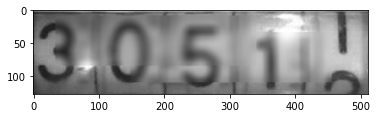

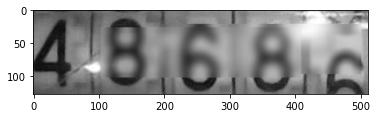

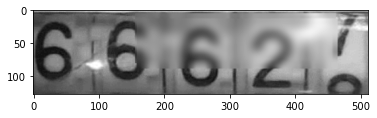

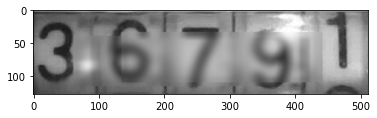

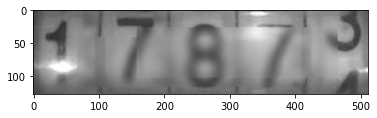

n	size	fid(easy,dist)	fid(diff,dist)
2	0.600000	155.070606	211.785664


In [17]:
def blur_squares(image, size_rel, n, kernel_rel):
    k_absolute = int(fid_inputHeight * kernel_rel)
    kernel = (k_absolute,k_absolute)
    #size = int(fid_inputHeight * size_rel)
    for i in range(n):
        x0, y0, x1, y1 = distortions._random_region(image, relative_heightRange=(size_rel,size_rel), relative_widthRange=(size_rel,size_rel))
        region = image[y0:y1, x0:x1]
        region = cv2.blur(region, kernel)
        image[y0:y1, x0:x1] = region[:, :]
        
n_values = [2]
sizes = [0.6]


results = []
k_r = 0.1
for n in n_values:
    for size in sizes:
        print("%d, %f" % (n, size) )
        fid_easy_distorted, fid_diff_distorted = caluclate_FID(
                                                    lambda image: blur_squares(image, size, n, k_r),
                                                    n_show=5)
        results.append( (n,size, fid_easy_distorted, fid_diff_distorted) )
print("n\tsize\tfid(easy,dist)\tfid(diff,dist)")
for row in results:
    print("%d\t%f\t%f\t%f" % (row[0],row[1],row[2],row[3]) )

In [13]:
print("n\tsize\tfid(easy,dist)\tfid(diff,dist)")
for row in results:
    print("%d\t%f\t%f\t%f" % (row[0],row[1],row[2],row[3]) )

n	size	fid(easy,dist)	fid(diff,dist)
1	0.100000	2.814134	288.042278
1	0.200000	15.210194	275.131744
1	0.400000	56.173408	243.782687
5	0.100000	22.934436	274.995653
5	0.200000	126.354228	272.116829
5	0.400000	262.154813	273.484137
10	0.100000	54.281580	265.847469
10	0.200000	249.431445	315.419765
10	0.400000	329.395217	296.157585
20	0.100000	128.617680	256.722787
20	0.200000	364.868073	372.478639
20	0.400000	359.312773	318.294096
50	0.100000	292.955442	279.031956
50	0.200000	407.640270	385.113654
50	0.400000	387.611381	358.342242


In [10]:
---

SyntaxError: invalid syntax (<ipython-input-10-29e0c3615294>, line 1)

In [ ]:
# local blur
def blur_local(image, k_size_rel, horizontal=True):
    k_absolute = int(fid_inputHeight * k_size_rel)
    kernel = (k_absolute,k_absolute)
    
    if horizontal:
        region_width = 0.2
        region_height = 0.25    
    else:
        region_width = 0.05
        region_height = 0.9
        
    x0, y0, x1, y1 = distortions._random_region(image, relative_heightRange=(region_height,region_height), relative_widthRange=(region_width,region_width))
    region = image[y0:y1, x0:x1]
    region = cv2.blur(region, kernel)
    image[y0:y1, x0:x1] = region[:, :]
def blur_local_multiple(image, k_size_rel, horizontal=True, n=1):
    for i in range(n):
        blur_local(image, k_size_rel, horizontal)
        
n_values = [1,3,5,10, 20]
horizontal_values = [True, False]
results = []
for isHorizontal in horizontal_values:
    for n in n_values:
        fid_easy_distorted, fid_diff_distorted = caluclate_FID(
                                                    lambda image: blur_local_multiple(image, 0.04, isHorizontal, n),
                                                    n_show=5)
        alignment = "H" if isHorizontal else "V"
        results.append( (n,alignment, fid_easy_distorted, fid_diff_distorted) )

        
print("n\t\alignment\t\tfid(easy,dist)\t\tfid(diff,dist)")
for row in results:
    print("%d\t\t%s\t\t%f\t\t%f" % (row[0],row[1],row[2],row[3]) )
    
    

In [ ]:
------------

In [ ]:
# global blur
kernel_sizes = [k * 0.02 for k in range(1,10)] # relative to imageheight
def global_blur(image, kernel):
    image[:,:] = cv2.blur(image, kernel)
kernel_sizes=[0.2]
for k_relative in kernel_sizes:
    print(k_relative)
    k_absolute = int(fid_inputHeight * k_relative)
    kernel = (k_absolute,k_absolute)
    print(kernel)
    fid_easy_distorted, fid_diff_distorted = caluclate_FID(
                                                    lambda image: global_blur(image, kernel),
                                                    n_show=5)
    results.append( (k_relative,k_absolute, fid_easy_distorted, fid_diff_distorted) )
    
print("k_real\t\k_absolute\t\tfid(easy,dist)\t\tfid(diff,dist)")
for row in results:
    print("%f\t\t%d\t\t%f\t\t%f" % (row[0],row[1],row[2],row[3]) )

In [ ]:
# for brigthening dark pixels, try some values for brightening_value and treshold
values = [30,60,90]
tresholds = [30,60,90]
results = []
for value in values:
    for treshold in tresholds:
        fid_easy_distorted, fid_diff_distorted = caluclate_FID(
                                                    lambda image: distortions.brighten_digits(image, value, treshold),
                                                    n_show=30)
        results.append( (value,treshold, fid_easy_distorted, fid_diff_distorted) )
        
print("val\t\ttresh\t\tfid(easy,dist)\t\tfid(diff,dist)")
for row in results:
    print("%d\t\t%d\t\t%f\t\t%f" % (row[0],row[1],row[2],row[3]) )

In [ ]:
n=5
images_easy, labels_easy = load_realdata.load_wmr_easy(n_toLoad=n, resizeTo=fid_inputDims, keepRatio=False)   
values = [30,60,90]
tresholds = [30,60,90]
for value in values:
    for treshold in tresholds:
        print("%d,%d" %(value, treshold) )
        result = apply_distortions(images_easy, lambda image: distortions.brighten_digits(image, value, treshold) )
        showImages(result)

# --------------- 

In [ ]:
---------------------

In [ ]:
    
#modelsavepath = Path("D:/m2/evaluations/fcsrn/distortions/brigthen_blur")
modelsavepath = Path("D:/m2/evaluations/fcsrn/distortions/ident")
calculate_FCSRN_AR(ident, modelsavepath)

In [ ]:
# brighten
def brighten_0(image):
    v_range = (100,130)
    treshold = 80
    brighten_digits(image, v_range, treshold)
modelsavepath = Path("D:/m2/evaluations/fcsrn/distortions/brighten_100_130_80")
caluclate_FID(brighten_0)
calculate_FCSRN_AR(brighten_0, modelsavepath)

In [ ]:
caluclate_FID(blur_region)
modelsavepath = Path("D:/m2/evaluations/fcsrn/distortions/blur_0")
calculate_FCSRN_AR(blur_region, modelsavepath)

In [ ]:
def blur_brighten(image):
    brighten_0(image)
    blur_region(image)
    
caluclate_FID(blur_brighten)
modelsavepath = Path("D:/m2/evaluations/fcsrn/distortions/blur_brighten_0")
calculate_FCSRN_AR(blur_brighten, modelsavepath)